In [8]:
import nibabel as nib
import numpy as np
from collections import defaultdict
import os

In [9]:
nsd_mask_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_nsd/sub-01/nsdgeneral.nii.gz"
dk_atlas_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_hf_dk/DK-atlas-fmri.nii.gz"
beta_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/nsdgeneral.npy"
#output_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_hf_dk"
#os.makedirs(output_dir, exist_ok=True)

nsd_mask = nib.load(nsd_mask_path).get_fdata().flatten()
dk_atlas = nib.load(dk_atlas_path).get_fdata().flatten()
beta = np.load(beta_path)


In [10]:
valid_idx = np.where(nsd_mask == 1)[0]
dk_labels = dk_atlas[valid_idx]

cortical_labels = [v for v in np.unique(dk_labels) if 1000 <= v <= 1035 or 2000 <= v <= 2035]

In [11]:
dk_dict = {}

for label in cortical_labels:
    idx = np.where(dk_labels == label)[0]
    dk_dict[int(label)] = beta[:, idx]

max_voxels = max(arr.shape[1] for arr in dk_dict.values())

padded_dict = {}
for label, data in dk_dict.items():
    original_shape = data.shape
    pad_width = max_voxels - data.shape[1]
    if pad_width > 0:
        padded = np.pad(data, ((0,0), (0, pad_width)), mode='constant')
    else:
        padded = data
    padded_dict[label] = padded
    print(f"Label {label}: original shape {original_shape}, padded shape {padded.shape}")



all_data = np.stack([padded_dict[label] for label in sorted(padded_dict.keys())], axis=0)
all_data = np.transpose(all_data, (1, 0, 2))

#np.save(os.path.join(output_dir, "beta_dk_padded_test.npy"), all_data)
#np.save(os.path.join(output_dir, "beta_dk_labels_test.npy"), np.array(sorted(padded_dict.keys())))


print(f"\nFinal stacked shape: {all_data.shape}")  # 전체 shape 확인
print(f"DK labels: {sorted(padded_dict.keys())}")  # 라벨 확인


Label 1005: original shape (25611, 215), padded shape (25611, 2056)
Label 1007: original shape (25611, 910), padded shape (25611, 2056)
Label 1008: original shape (25611, 760), padded shape (25611, 2056)
Label 1009: original shape (25611, 180), padded shape (25611, 2056)
Label 1011: original shape (25611, 2056), padded shape (25611, 2056)
Label 1013: original shape (25611, 978), padded shape (25611, 2056)
Label 1015: original shape (25611, 118), padded shape (25611, 2056)
Label 1016: original shape (25611, 57), padded shape (25611, 2056)
Label 1021: original shape (25611, 235), padded shape (25611, 2056)
Label 1029: original shape (25611, 258), padded shape (25611, 2056)
Label 2005: original shape (25611, 200), padded shape (25611, 2056)
Label 2007: original shape (25611, 804), padded shape (25611, 2056)
Label 2008: original shape (25611, 620), padded shape (25611, 2056)
Label 2009: original shape (25611, 225), padded shape (25611, 2056)
Label 2011: original shape (25611, 1977), padded

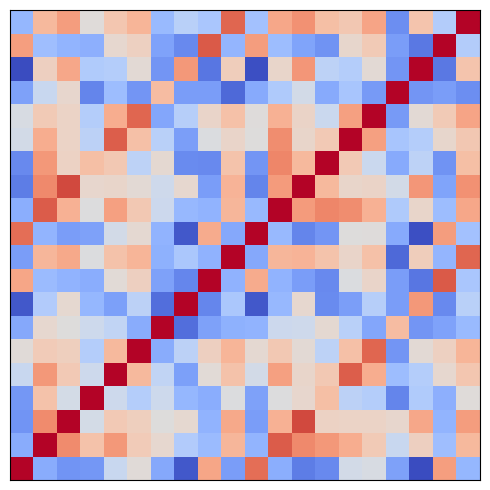

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# all_data: (n_samples, n_rois, n_voxels)  →  (982, 20, 2056)
# labels: [1005, 1007, …, 2029] 순서대로 정렬된 ROI 레이블 리스트

# 1) ROI별 복셀 평균 → 시계열 생성 (shape: [n_samples, n_rois])
roi_timeseries = all_data.mean(axis=2)

# 2) ROI 간 상관행렬 계산 (shape: [n_rois, n_rois])
#    np.corrcoef는 기본적으로 행(row)을 변수로, 열(col)을 관측치로 취급하므로
corr_mat = np.corrcoef(roi_timeseries, rowvar=False)

# 3) 히트맵 그리기
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_mat,
    origin='lower',
    cmap='coolwarm',
    aspect='equal')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(label, rotation=90, fontsize=8)
#ax.set_yticklabels(label, fontsize=8)
#ax.set_title('ROI 간 상관행렬')
#plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import pandas as pd
import os

# 경로
data_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_hf_dk"
new_beta_path = os.path.join(data_path, "beta_dk_padded_test.npy")
tsv_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_huggingface/mapped_img_test.tsv"
output_path = os.path.join(data_path, "beta_hf_dk_test.npz")

# 파일 로드
new_beta_data = np.load(new_beta_path)
img_list = pd.read_csv(tsv_path, sep='\t', header=None)[0].values 

# sanity check
assert new_beta_data.shape[0] == img_list.shape[0], "데이터 개수가 일치하지 않음!"

# 저장
np.savez_compressed(output_path, X=new_beta_data, Y=img_list)
print(f"저장 완료: {output_path}")

저장 완료: /nas/research/03-Neural_decoding/3-bids/derivatives/beta_hf_dk/beta_hf_dk_test.npz


In [34]:
import numpy as np

# 파일 경로
npz_path = "/nas/research/03-Neural_decoding/3-bids/derivatives/beta_hf_dk/beta_hf_dk_test.npz"

# 로드
data = np.load(npz_path, allow_pickle=True)

# 키 확인
print("파일 내 포함된 키들:", data.files)

# 각 배열의 shape 확인
for key in data.files:
    print(f"{key}: shape {data[key].shape}")

# 값 일부 확인 (예시: 앞 3개 beta와 이미지 이름)
print("\n예시 beta[0]의 shape:", data['X'][0].shape)
print("예시 beta[0][0][:5]:", data['X'][0][0][:982])
print("예시 image_names[:5]:", data['Y'][:5])


파일 내 포함된 키들: ['X', 'Y']
X: shape (982, 20, 2056)
Y: shape (982,)

예시 beta[0]의 shape: (20, 2056)
예시 beta[0][0][:5]: [ 9.2480e-01 -1.9983e-01 -2.5684e-01 -8.3862e-02  3.2812e-01 -5.4688e-01
  6.7969e-01  2.2791e-01 -1.0215e+00  4.3042e-01  5.8789e-01  3.0371e-01
 -4.9219e-01  7.5830e-01  7.0862e-02 -6.0303e-02 -1.1993e-01  1.0615e+00
 -1.7273e-01  3.7744e-01  6.5186e-01 -4.5801e-01 -8.2959e-01  2.5098e-01
  1.0859e+00  3.8818e-01 -8.5205e-01 -4.8608e-01 -5.2441e-01  6.6223e-02
 -4.6936e-02  2.0962e-03  2.3560e-01  3.0078e-01  9.5996e-01  5.8789e-01
 -2.6904e-01  1.0020e+00  1.9165e-01  6.6699e-01  3.0106e-02  1.9688e+00
 -8.8428e-01 -2.9907e-01  7.6025e-01 -5.3986e-02  4.1016e-01  7.9688e-01
  5.5933e-04  8.1738e-01  1.2939e-01 -1.4783e-01 -4.4751e-01 -1.1346e-01
 -4.9756e-01 -4.6411e-01 -1.9852e-02 -4.9829e-01  5.9473e-01 -2.6709e-01
 -4.9048e-01 -1.6272e-01  1.7236e-01  1.9226e-01 -9.5764e-02 -7.5098e-01
  2.7100e-01  4.4751e-01  3.4644e-01 -2.8296e-01 -6.3428e-01 -1.4331e-01
 -2.9590e